In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [3]:
DAE_np_data_path = r'data\np\npData.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [4]:
np_DAE_df = np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

In [5]:
df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section 

})
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])

df = df[df['E_inc'] != 2.5e8]

In [6]:
import torch
import numpy as np
import pandas as pd


def prepare_experimental_data(df):

    # incident energy 
    E_inc_unique  = sorted(df['E_inc'].unique())

    # create the grid
    E_sec_unique  = np.asarray(sorted(df['E_sec'].unique()),  dtype=float)
    theta_unique  = np.asarray(sorted(df['theta'].unique()), dtype=float)

    # create the 2D distribution
    out = []
    for E_inc in E_inc_unique:
        # Sub-select rows for this incident energy
        sub = df[df['E_inc'] == E_inc]

        # Pivot into a full 2-D grid; reindex to guarantee rectangular shape
        grid = (
            sub.pivot(index='E_sec', columns='theta', values='ddcs')
               .reindex(index=E_sec_unique, columns=theta_unique)
               .fillna(0.0)
               .to_numpy()
        )

        out.append({
            'E_inc' : torch.tensor(E_inc,        dtype=torch.float32),
            'E_sec' : torch.tensor(E_sec_unique, dtype=torch.float32),
            'theta' : torch.tensor(theta_unique, dtype=torch.float32),
            'ddcs'  : torch.tensor(grid,         dtype=torch.float32)
        })

    return out

In [7]:
out = prepare_experimental_data(df)

# same as out, but cs are integrated over theta and E_sec
# This will give us the integrated results for each incident energy
integrated_results = []

for d in out:
    E_inc = d['E_inc']
    E_sec = d['E_sec']
    theta = d['theta']
    ddcs = d['ddcs']

    int_theta = torch.trapz(ddcs, theta, dim=1)  # integrate over theta
    int_Esec = torch.trapz(ddcs, E_sec, dim=0)  # integrate over E_sec

    integrated_results.append({
        'E_inc': E_inc,
        'E_sec': E_sec,
        'theta': theta,
        'int_over_theta': int_theta,
        'int_over_E_sec': int_Esec
    })



In [8]:

def plot_integrated_cross_sections(integrated_results):
    for data in integrated_results:
        E_inc = data['E_inc'].item()  # scalar float
        E_sec = data['E_sec'].numpy()
        theta = data['theta'].numpy()
        int_over_theta = data['int_over_theta'].numpy()
        int_over_E_sec = data['int_over_E_sec'].numpy()

        # Plot integrated over theta (cross section vs E_sec)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.plot(E_sec, int_over_theta, marker='o')
        plt.xlabel('Secondary Energy $E_{sec}$')
        plt.ylabel('Integrated Cross Section (over θ)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        # Plot integrated over E_sec (cross section vs theta)
        plt.subplot(1, 2, 2)
        plt.plot(theta, int_over_E_sec, marker='o')
        plt.xlabel('Scattering Angle θ')
        plt.ylabel('Integrated Cross Section (over $E_{sec}$)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        plt.tight_layout()
        plt.show()

# plot_integrated_cross_sections(integrated_results)

In [9]:
import math
import torch
import torch.nn as nn
from torch.autograd import Function

# ---------------------------
# Minimal NPReactionSimulator (batched only)
# ---------------------------
class NPReactionSimulator(nn.Module):
    def __init__(self, m_n=939.565, m_p=938.272, M_A=29785.0, S_n=7.70, S_p=13.46):
        super().__init__()
        self.register_buffer("m_n", torch.tensor(float(m_n)))
        self.register_buffer("m_p", torch.tensor(float(m_p)))
        self.register_buffer("M_A", torch.tensor(float(M_A)))
        self.register_buffer("S_n", torch.tensor(float(S_n)))
        self.register_buffer("S_p", torch.tensor(float(S_p)))

    def forward(self, Ek, r1, r2, r3):
        # Ek: (B,) or (B,1) -> expand to (B, N)
        if Ek.dim() == 1:
            Ek = Ek.unsqueeze(1).expand(-1, r1.shape[1])
        elif Ek.shape[1] == 1:
            Ek = Ek.expand(-1, r1.shape[1])

        m_n, m_p, M_A, S_n, S_p = (
            self.m_n.to(Ek),
            self.m_p.to(Ek),
            self.M_A.to(Ek),
            self.S_n.to(Ek),
            self.S_p.to(Ek)
        )

        denom = (M_A + m_n) ** 2
        Tk = (Ek ** 2) * m_n / (denom + 1e-12)
        Ex = Ek - Tk + S_n
        available_E = Ex - S_p
        mask = available_E > 0

        Ep_com = r1 * available_E
        E_p_com = Ep_com + m_p
        p_mag_com = torch.sqrt(torch.clamp(E_p_com**2 - m_p**2, min=0.0))

        cos_theta_com = r2
        sin_theta_com = torch.sqrt(torch.clamp(1.0 - cos_theta_com**2, min=0.0))
        phi = r3

        px_com = p_mag_com * sin_theta_com * torch.cos(phi)
        py_com = p_mag_com * sin_theta_com * torch.sin(phi)
        pz_com = p_mag_com * cos_theta_com

        M_recoil = M_A + m_n
        beta = torch.clamp(Tk / (M_recoil + 1e-12), max=0.999999)
        gamma = 1.0 / torch.sqrt(torch.clamp(1.0 - beta**2, min=1e-12))

        E_lab = gamma * (E_p_com + beta * pz_com)
        pz_lab = gamma * (pz_com + beta * E_p_com)
        p_mag_lab = torch.sqrt(px_com**2 + py_com**2 + pz_lab**2 + 1e-12)

        Ep_lab = torch.where(mask, E_lab - m_p, torch.zeros_like(E_lab))
        cos_theta_lab = torch.where(mask, pz_lab / (p_mag_lab + 1e-12), torch.zeros_like(pz_lab))
        return Ep_lab, cos_theta_lab


# ---------------------------
# Minimal DifferentiableKDE (batched only)
# ---------------------------
class DifferentiableKDE(nn.Module):
    def __init__(self, x_eval, bandwidth=0.6, normalize=True):
        super().__init__()
        self.register_buffer("x_eval", x_eval.view(-1))
        self.bandwidth = float(bandwidth)
        self.normalize = bool(normalize)
        self.register_buffer("sqrt_2pi", torch.tensor(math.sqrt(2 * math.pi), dtype=torch.float32))

    def forward(self, samples, weights=None):
        # samples: (B, N)
        B, N = samples.shape
        M = self.x_eval.numel()

        if weights is None:
            weights = torch.ones_like(samples)

        x = self.x_eval.view(M, 1, 1)
        s = samples.view(1, B, N)

        diffs = (x - s) / self.bandwidth
        kernel_vals = torch.exp(-0.5 * diffs**2) / (self.bandwidth * self.sqrt_2pi)

        w = weights.view(1, B, N)
        density = (kernel_vals * w).sum(dim=2) / (w.sum(dim=2) + 1e-12)

        density = density.permute(1, 0).contiguous()  # (B, M)

        if self.normalize:
            dx = (self.x_eval[1:] - self.x_eval[:-1]).mean().clamp(min=1e-12)
            density /= (density.sum(dim=1, keepdim=True) * dx + 1e-12)

        return density  # (B, M)


# ---------------------------
# Minimal Pipeline
# ---------------------------
class ACSPipeline(nn.Module):
    def __init__(self, cos_theta_eval, kde_bandwidth=0.05):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.kde_theta = DifferentiableKDE(x_eval=cos_theta_eval, bandwidth=kde_bandwidth)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.kde_theta(cos_theta_lab, weights=valid)
    
class ECSPipeline(nn.Module):
    def __init__(self, E_eval, kde_bandwidth=0.3):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.kde_E = DifferentiableKDE(x_eval=E_eval, bandwidth=kde_bandwidth)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, _ = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.kde_E(Ep_lab, weights=valid)
    

# -------------------------------
# ACS autograd wrapper
# -------------------------------
class NPACSSimulationFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, Ek, r1, r2, r3, acs_pipeline: nn.Module):
        """
        Forward: runs ACS simulation pipeline
        Inputs:
            Ek: (B,)
            r1,r2,r3: (B,N)
            acs_pipeline: instance of ACSPipeline
        Returns:
            dsigma_dOmega: (B, M)
        """
        ctx.save_for_backward(r1, r2, r3, Ek)
        ctx.pipeline = acs_pipeline

        # Run pipeline
        dsigma_dOmega = acs_pipeline(Ek, r1, r2, r3)  # (B, M)
        return dsigma_dOmega

    @staticmethod
    def backward(ctx, grad_output):
        r1, r2, r3, Ek = ctx.saved_tensors
        B, N = r1.shape

        # Simple straight-through surrogate gradient: broadcast grad_output to match r1/r2/r3
        grad_r1 = grad_output.mean(dim=1, keepdim=True).expand_as(r1)
        grad_r2 = grad_output.mean(dim=1, keepdim=True).expand_as(r2)
        grad_r3 = grad_output.mean(dim=1, keepdim=True).expand_as(r3)

        grad_Ek = None   # do not backprop through Ek
        return grad_Ek, grad_r1, grad_r2, grad_r3, None

# Helper wrapper
def run_acs_autograd(Ek, r1, r2, r3, pipeline: ACSPipeline):
    return NPACSSimulationFunction.apply(Ek, r1, r2, r3, pipeline)


# -------------------------------
# ECS autograd wrapper
# -------------------------------
class NPECSSimulationFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, Ek, r1, r2, r3, ecs_pipeline: nn.Module):
        ctx.save_for_backward(r1, r2, r3, Ek)
        ctx.pipeline = ecs_pipeline

        dsigma_dE = ecs_pipeline(Ek, r1, r2, r3)  # (B, M)
        return dsigma_dE

    @staticmethod
    def backward(ctx, grad_output):
        r1, r2, r3, Ek = ctx.saved_tensors
        B, N = r1.shape

        # Straight-through surrogate gradient
        grad_r1 = grad_output.mean(dim=1, keepdim=True).expand_as(r1)
        grad_r2 = grad_output.mean(dim=1, keepdim=True).expand_as(r2)
        grad_r3 = grad_output.mean(dim=1, keepdim=True).expand_as(r3)

        grad_Ek = None
        return grad_Ek, grad_r1, grad_r2, grad_r3, None

# Helper wrapper
def run_ecs_autograd(Ek, r1, r2, r3, pipeline: ECSPipeline):
    return NPECSSimulationFunction.apply(Ek, r1, r2, r3, pipeline)


In [10]:
# import torch
# import math
# import matplotlib.pyplot as plt
# import numpy as np

# # --- from your data ---
# E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
# E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
# cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Parameters
# B = len(E_inc_unique)  # one batch per experimental incoming energy
# N = 2000               # MC samples per Ek

# # Expand energies to batch
# Ek_batch = E_inc_unique.to(device)  # shape [B]

# # Random Monte Carlo parameters
# r1 = torch.rand((B, N), device=device)
# r2 = torch.rand((B, N), device=device) * 2 - 1
# r3 = torch.rand((B, N), device=device) * 2 * math.pi - math.pi

# # Create pipeline
# # pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)
# pipeline = ECSPipeline(E_eval=E_sec_exp).to(device)


# # Run simulation
# with torch.no_grad():
#     dsigma = pipeline(Ek_batch, r1, r2, r3)  # shape [B, M]

# print("dsigma shape:", dsigma.shape)

# # Plot results
# fig, axes = plt.subplots(1, B, figsize=(4 * B, 4), sharey=True)
# if B == 1:
#     axes = [axes]

# for i, ax in enumerate(axes):
#     # ax.plot(cos_theta_exp.cpu(), dsigma[i].cpu(), 'b-', lw=2)
#     ax.plot(E_sec_exp.cpu(), dsigma[i].cpu(), 'b-', lw=2)
#     # ax.set_title(f"E_k = {Ek_batch[i].item():.2f} MeV")
#     ax.set_xlabel(r"$\cos\theta$")
#     if i == 0:
#         ax.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (arb. units)")

# plt.tight_layout()
# plt.show()


In [11]:
# # TESTING 
# pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

# Ek_batch = torch.tensor([70.0], device=device)  # Example single energy, shape [B]

# r1 = torch.tensor([[0.5]], device=device)
# r1 = torch.tensor([[0.5]], device=device)
# r1 = torch.tensor([[0.5]], device=device)


# # Run simulation
# with torch.no_grad():
#     dsigma = pipeline(Ek_batch, r1, r2, r3)

# dsigma

In [23]:
import torch
import torch.nn.functional as F

def kl_plus_sum_mse_loss(simulated_ddcs, experimental_ddcs, eps=1e-8, mse_weight=0.1):
    # KL (shape)
    sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
    exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

    sim_dist = simulated_ddcs / sim_sum
    exp_dist = experimental_ddcs / exp_sum

    sim_dist = torch.clamp(sim_dist, min=eps)
    exp_dist = torch.clamp(exp_dist, min=eps)

    kl = F.kl_div(sim_dist.log(), exp_dist, reduction='batchmean', log_target=False)

    # MSE (scale)
    mse_sums = F.mse_loss(sim_sum, exp_sum)

    # Combine
    loss = kl + mse_weight * mse_sums
    return loss


def kl_mse_combined_loss(simulated_ddcs, experimental_ddcs, eps=1e-8, mse_weight=0.00001):
    """
    Combines:
      - KL divergence on normalized distributions (shape)
      - Pointwise MSE on raw values (scale & shape)

    Args:
        simulated_ddcs: (B, M) predicted differential cross section
        experimental_ddcs: (B, M) target differential cross section
        eps: small number for numerical stability
        mse_weight: relative weight of the MSE term

    Returns:
        scalar loss
    """
    # --- KL on normalized ---
    sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
    exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

    sim_dist = simulated_ddcs / sim_sum
    exp_dist = experimental_ddcs / exp_sum

    sim_dist = torch.clamp(sim_dist, min=eps)
    exp_dist = torch.clamp(exp_dist, min=eps)

    kl = F.kl_div(sim_dist.log(), exp_dist, reduction='batchmean', log_target=False)

    # --- MSE on raw values ---
    mse_pointwise = F.mse_loss(simulated_ddcs, experimental_ddcs)

    # --- Combine ---
    loss = kl + mse_weight * mse_pointwise
    return loss

def mse_loss_log(pred, target, eps=1e-8):
    pred = torch.clamp(pred, min=eps)
    target = torch.clamp(target, min=eps)
    return torch.mean((torch.log(pred) - torch.log(target)) ** 2)


def wasserstein_1d_loss(mc_samples: torch.Tensor, exp_samples: torch.Tensor):
    """
    Compute 1D Wasserstein (Earth Mover's) distance between two sample tensors.
    Both tensors should be 1D: (batch_size,)
    """
    # Sort samples
    mc_sorted, _ = torch.sort(mc_samples)
    exp_sorted, _ = torch.sort(exp_samples)
    
    # Pad smaller tensor if needed (optional)
    n_mc = mc_sorted.shape[0]
    n_exp = exp_sorted.shape[0]
    if n_mc != n_exp:
        # Simple linear interpolation to match sizes
        exp_sorted = torch.interp(
            torch.linspace(0, 1, steps=n_mc, device=mc_samples.device),
            torch.linspace(0, 1, steps=n_exp, device=mc_samples.device),
            exp_sorted
        )
    
    # Wasserstein distance: average absolute difference
    loss = torch.mean(torch.abs(mc_sorted - exp_sorted))
    return loss



In [28]:
# ------------------------------------------------------------------
# Hyper-parameters
# ------------------------------------------------------------------
n_in        = 3       # number of parameters, i.e., random numbers needed in the simulation
n_lamda     = 1       # number of untrainable external parameter dependencies
n_hidden    = 24      # number of hidden neurons in the network, at each layer
n_layers    = 6#3       # number of hidden layers in the network
n_out       = n_in    # must match the number of output parameters
batch_size  = 64 #2_000   # samples of random number per batch, to build the distribution. Larger is better, but slower
n_mc_samples = 1024
epochs      = 1000 #0   # number of epochs to train the network
lr          = 1e-3    # learning rate for the optimizer

# ------------------------------------------------------------------
# MLP producing seeds in [0,1]
# ------------------------------------------------------------------
def make_mlp(n_in, n_lamda, n_hidden, n_layers, n_out):
    layers, d = [], n_in + n_lamda
    for _ in range(n_layers):
        layers += [nn.Linear(d, n_hidden), nn.ReLU()]
        d = n_hidden
    layers += [nn.Linear(d, n_out), nn.Sigmoid()]
    return nn.Sequential(*layers)

net       = make_mlp(n_in, n_lamda, n_hidden, n_layers, n_out).to(device)

E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# f_layer   = NPACSSimulationLayer(cos_theta_eval=cos_theta_exp).to(device) 
# f_layer   = NPECSSimulationLayer(E_eval=E_sec_exp).to(device)

optimiser = optim.Adam(net.parameters(), lr=lr)
# ------------------------------------------------------------------

In [31]:
from tqdm import trange

# ---------------------------
# Create ACS/ECS simulation layer (autograd-friendly)
# ---------------------------
E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# Prep experimental data
all_Ek = torch.stack([res['E_inc'] for res in integrated_results]) / 1e6  # (N,)
# all_exp = torch.stack([res['int_over_E_sec'] for res in integrated_results])  # (N, M)
all_exp = torch.stack([res['int_over_theta'] for res in integrated_results])  # (N, dist_len)

all_Ek = all_Ek.to(device)
all_exp = all_exp.to(device)
num_samples_total = all_Ek.shape[0]

ecs_pipeline = ECSPipeline(E_eval=E_sec_exp).to(device)
acs_pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

# -------------
# Training loop
# -------------

# ==== Debug toggles ====
USE_FIXED_IDX = False        # True = always use the same idx for Ek
FIXED_IDX_VALUE = 0          # which dataset entry to use if above is True
USE_FIXED_MC = False         # True = use the same MC samples each epoch

# Prepare fixed MC samples if needed
if USE_FIXED_MC:
    fixed_uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

# net.train()
# for epoch in trange(epochs, desc='Training Epochs'):

#     # ----- Index selection -----
#     if USE_FIXED_IDX:
#         idx = torch.full((batch_size,), FIXED_IDX_VALUE, dtype=torch.long, device=device)
#     else:
#         idx = torch.randint(0, num_samples_total, (batch_size,), device=device)

#     Ek_batch = all_Ek[idx]           # (B,)
#     dsigma_dOmega_exp = all_exp[idx] # (B, M)

#     # ----- MC samples -----
#     if USE_FIXED_MC:
#         uniform_samples = fixed_uniform_samples
#     else:
#         uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

#     # ----- Network forward -----
#     Ek_expanded = Ek_batch[:, None, None].expand(-1, n_mc_samples, 1)  # (B, N, 1)
#     net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)       # (B, N, n_in + 1)
#     net_input_flat = net_input.reshape(-1, n_in + 1)                     # flatten

#     t = net(net_input_flat).reshape(batch_size, n_mc_samples, n_in) # (B, N, n_in)

#     # Split seeds into r1,r2,r3 for the simulator
#     # r1, r2, r3 = seeds[..., 0], seeds[..., 1], seeds[..., 2]  # each (B, N)

#     r1 = t[:, :, 0]
#     r2 = t[:, :, 1] * 2 - 1
#     r3 = t[:, :, 2] * 2 * torch.pi - torch.pi

#     # ----- ACS forward pass -----
#     dsigma_dOmega_sim = run_acs_autograd(Ek_batch, r1, r2, r3, acs_pipeline)  # (B, M)

#     # ----- Loss -----
#     loss = kl_plus_sum_mse_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)

#     # ----- Backprop -----
#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()

#     if epoch % 100 == 0:
#         print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.6f}")


net.train()
for epoch in trange(epochs, desc='Training Epochs'):

    # ----- Index selection -----
    if USE_FIXED_IDX:
        idx = torch.full((batch_size,), FIXED_IDX_VALUE, dtype=torch.long, device=device)
    else:
        idx = torch.randint(0, num_samples_total, (batch_size,), device=device)

    Ek_batch = all_Ek[idx]           # (B,)
    dsigma_dE_exp = all_exp[idx]     # (B, M)  <- ECS experimental data

    # ----- MC samples -----
    if USE_FIXED_MC:
        uniform_samples = fixed_uniform_samples
    else:
        uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

    # ----- Network forward -----
    Ek_expanded = Ek_batch[:, None, None].expand(-1, n_mc_samples, 1)  # (B, N, 1)
    net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)       # (B, N, n_in + 1)
    net_input_flat = net_input.reshape(-1, n_in + 1)                     # flatten

    t = net(net_input_flat).reshape(batch_size, n_mc_samples, n_in) # (B, N, n_in)

    # Split seeds into r1,r2,r3 for the simulator
    r1 = t[:, :, 0]
    r2 = t[:, :, 1] * 2 - 1
    r3 = t[:, :, 2] * 2 * torch.pi - torch.pi

    # ----- ECS forward pass -----
    dsigma_dE_sim = run_ecs_autograd(Ek_batch, r1, r2, r3, ecs_pipeline)  # (B, M)

    # ----- Loss -----
    loss = kl_plus_sum_mse_loss(dsigma_dE_sim, dsigma_dE_exp)

    # ----- Backprop -----
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.6f}")


Training Epochs:   0%|          | 1/1000 [00:00<03:45,  4.42it/s]

Epoch   1 | Loss: 13.282087


Training Epochs:  10%|█         | 102/1000 [00:20<02:52,  5.19it/s]

Epoch 101 | Loss: 13.623730


Training Epochs:  20%|██        | 202/1000 [00:39<02:33,  5.20it/s]

Epoch 201 | Loss: 13.660917


Training Epochs:  30%|███       | 302/1000 [00:58<02:11,  5.33it/s]

Epoch 301 | Loss: 13.684335


Training Epochs:  40%|████      | 402/1000 [01:17<01:54,  5.23it/s]

Epoch 401 | Loss: 13.690142


Training Epochs:  50%|█████     | 502/1000 [01:37<01:37,  5.13it/s]

Epoch 501 | Loss: 13.582735


Training Epochs:  60%|██████    | 602/1000 [01:56<01:17,  5.13it/s]

Epoch 601 | Loss: 13.740231


Training Epochs:  70%|███████   | 702/1000 [02:16<00:59,  5.02it/s]

Epoch 701 | Loss: 13.625931


Training Epochs:  80%|████████  | 802/1000 [02:35<00:38,  5.17it/s]

Epoch 801 | Loss: 13.740006


Training Epochs:  90%|█████████ | 902/1000 [02:54<00:18,  5.31it/s]

Epoch 901 | Loss: 13.671225


Training Epochs: 100%|██████████| 1000/1000 [03:13<00:00,  5.18it/s]


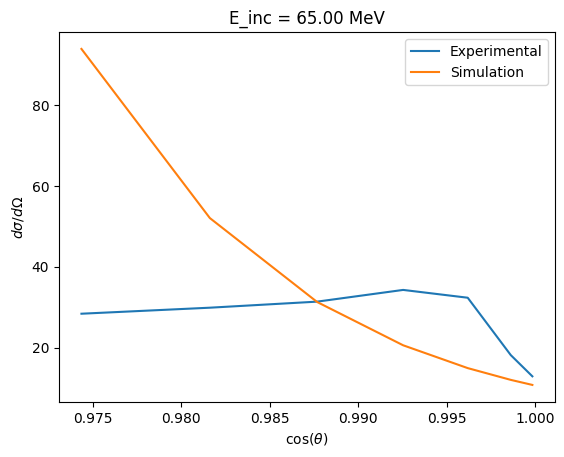

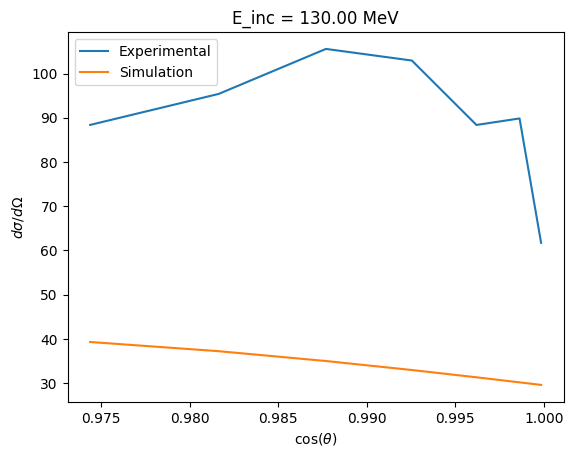

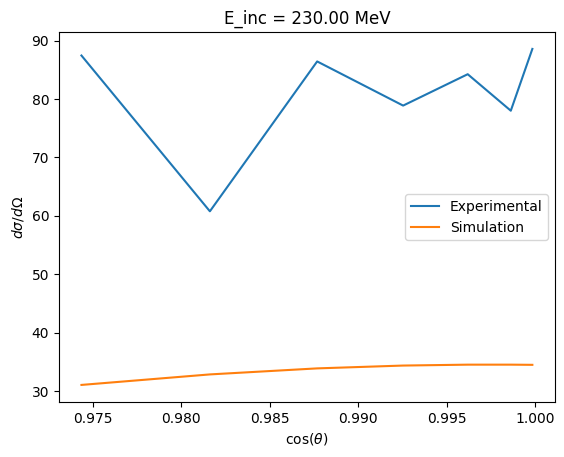

In [27]:
import torch
import matplotlib.pyplot as plt

net.eval()

n_mc_samples = 2000
monitor_indices = [0, len(integrated_results) // 2, -1]  # pick a few energies


for idx in monitor_indices:
    # Experimental values
    Ek_val = integrated_results[idx]['E_inc'] / 1e6  # scalar tensor

    exp_dist = integrated_results[idx]['int_over_E_sec'].to(device)  # (M,)
    # exp_dist = integrated_results[idx]['int_over_theta'].to(device)  # (M,)

    # Shape (B=1, N) for Monte Carlo
    Ek_batch = Ek_val.unsqueeze(0).to(device)  # (1,)
    Ek_expanded = Ek_batch.unsqueeze(1).expand(-1, n_mc_samples)  # (1, N)

    # Random latent samples: (B=1, N, n_in)
    uniform_samples = torch.rand((1, n_mc_samples, n_in), device=device)

    # Append Ek to each MC sample row: (1, N, n_in+1)
    net_input = torch.cat([uniform_samples, Ek_expanded.unsqueeze(-1)], dim=-1)

    # Flatten for net: (B*N, n_in+1)
    net_input_flat = net_input.reshape(-1, n_in + 1)

    with torch.no_grad():
        t = net(net_input_flat).reshape(1, n_mc_samples, 3)
        r1 = t[:, :, 0]
        r2 = t[:, :, 1] * 2 - 1
        r3 = t[:, :, 2] * 2 * torch.pi - torch.pi

        # Now acs_pipeline gets (B=1, N) inputs for r1, r2, r3
        sim_dist = acs_pipeline(Ek_batch, r1, r2, r3).squeeze(0)  # (M,)
        # sim_dist = ecs_pipeline(Ek_batch, r1, r2, r3).squeeze(0)  # (M,)


    # Plot
    plt.figure()
    plt.plot(cos_theta_exp.cpu(), exp_dist.cpu(), label='Experimental')
    plt.plot(cos_theta_exp.cpu(), sim_dist.cpu(), label='Simulation')
    plt.xlabel(r'$\cos(\theta)$')

    # plt.plot(E_sec_exp.cpu(), exp_dist.cpu(), label='Experimental')
    # plt.plot(E_sec_exp.cpu(), sim_dist.cpu(), label='Simulation')
    # plt.xlabel(r'$E_{\text{sec}}$ [MeV]')
    
    plt.ylabel(r'$d\sigma/d\Omega$')
    plt.title(f'E_inc = {Ek_val.item():.2f} MeV')
    plt.legend()
    plt.show()
